In [3]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage
import scipy
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage import morphology

# BEE DETECT

In [4]:
# Load all images from TRAIN
train_imgs = np.array([np.array(imageio.imread(filename)) for filename in glob.glob('../TRAIN/*.jpg')])

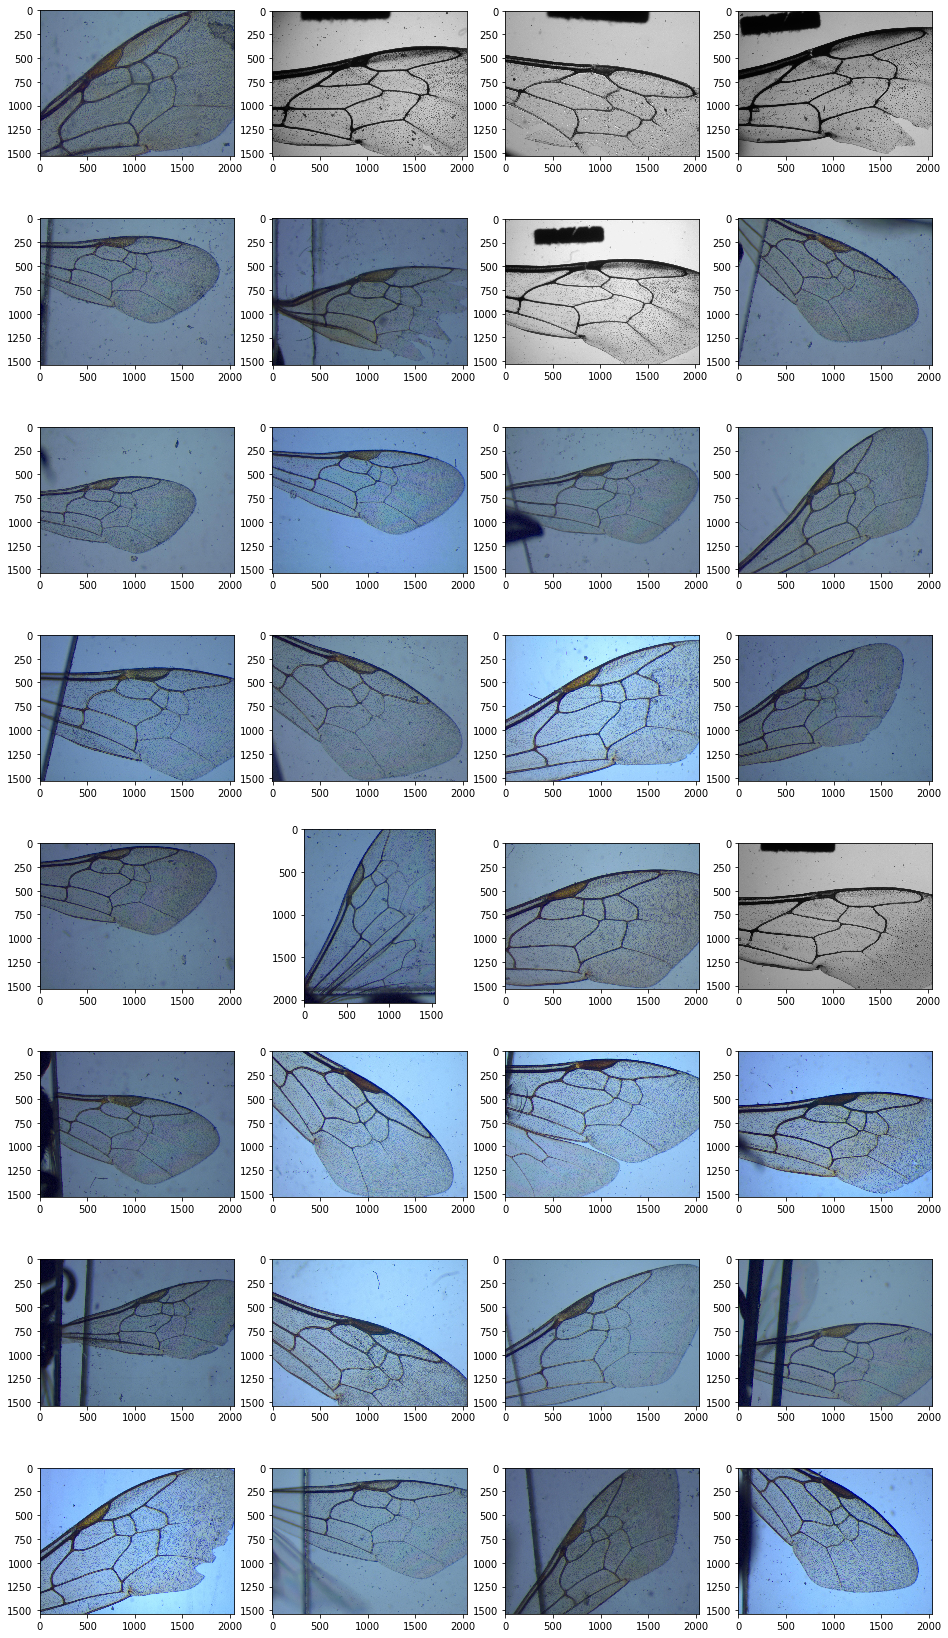

In [3]:
# Print all images from TRAIN
fig=plt.figure(figsize=(16, 30))
for i, img in enumerate(train_imgs):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(img)
plt.show()

In [4]:
# Load one image and CSV from TEST
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')

In [5]:
# Draw points from CSV on the image
def draw_points(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy,(int(point[1]), int(point[0])), 20, (255,255,0), -1)
    return img_copy

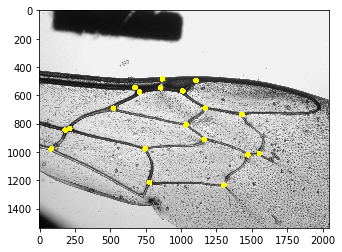

In [6]:
plt.imshow(draw_points(test_img, test_points))

## Threshold the image

In [7]:
img = train_imgs[0].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
#th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,179,28)
ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

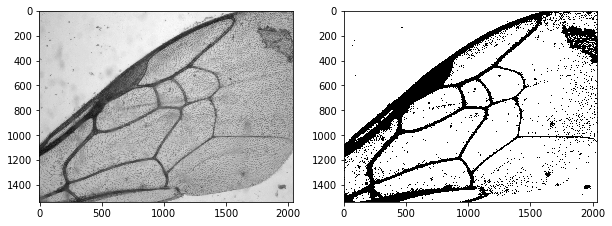

In [8]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')

fig.add_subplot(1, 2, 2)
plt.imshow(thresh, cmap='gray')

plt.show()

## Noise Removal

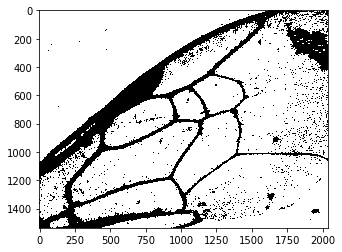

In [9]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
plt.imshow(opening, cmap='gray')

## Connected Components

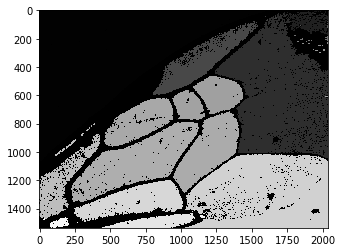

In [10]:
retval, markers = cv2.connectedComponents(opening)
plt.imshow(markers, cmap='gray')

## Watershed

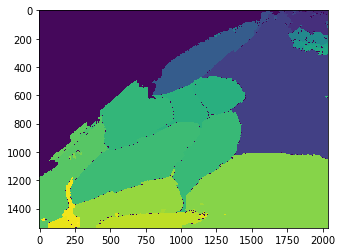

In [11]:
ws = cv2.watershed(img,markers)
plt.imshow(ws)

## Without Connected Components

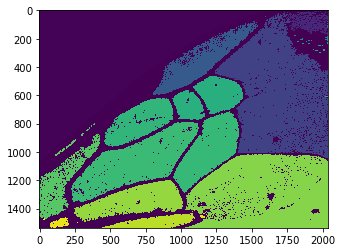

In [12]:
all_labels = skimage.measure.label(opening)
plt.imshow(all_labels)

# Results

In [13]:
def process(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    retval, markers = cv2.connectedComponents(opening)
    ws = cv2.watershed(img,markers)
    return ws

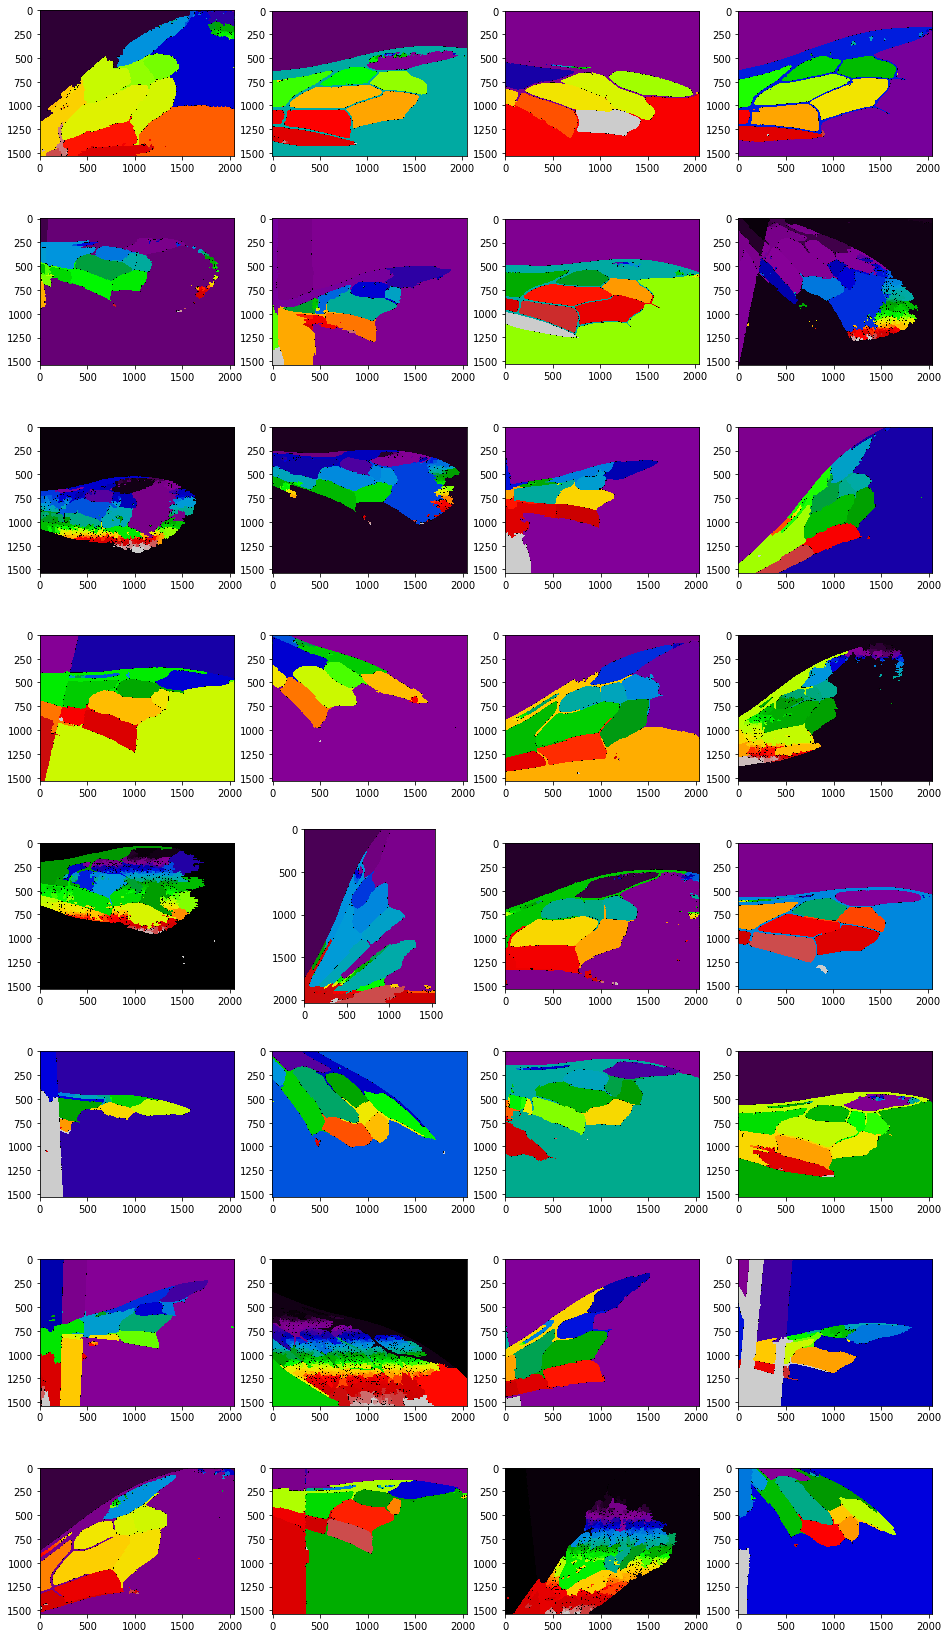

In [41]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process(img)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(ws, cmap='nipy_spectral')
plt.show()

## Without Connected Components

In [98]:
def process2(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    all_labels = skimage.measure.label(opening)
    return all_labels

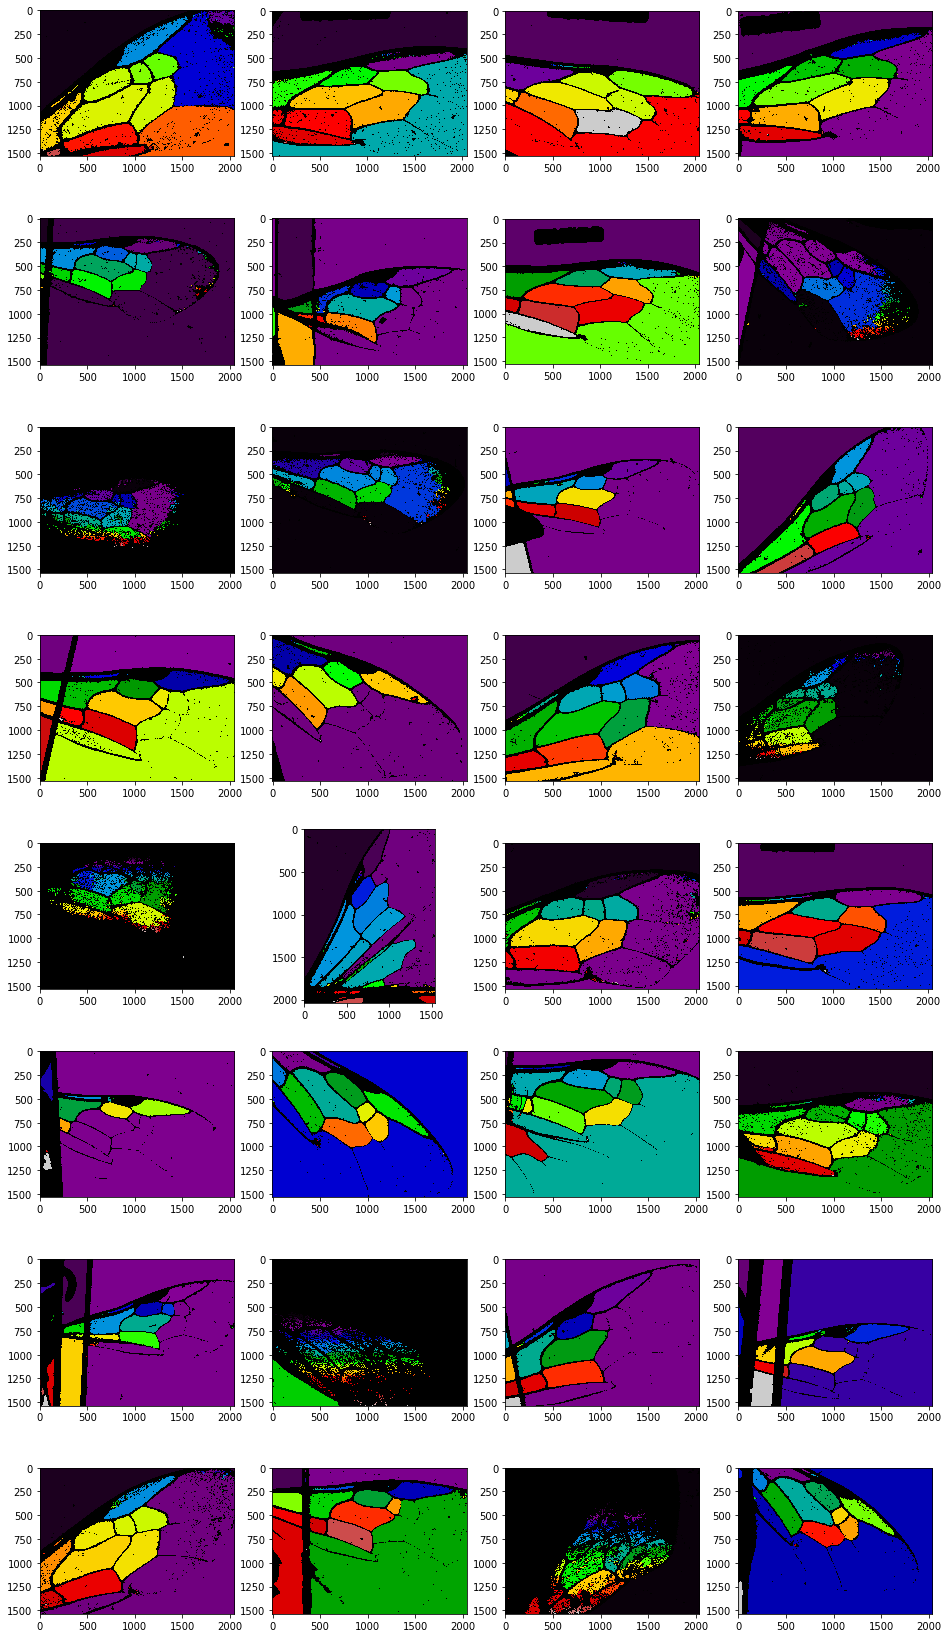

In [99]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process2(img)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(ws, cmap='nipy_spectral')
plt.show()


# Hugo changes

In [6]:
def process3(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = gray
    for i in range(20):
        blur = cv2.GaussianBlur(blur,(5,5),0)
    threshold_val = threshold_sauvola(blur, window_size=159)
    bin_img = (blur > threshold_val).astype(np.uint8)
    all_labels = skimage.measure.label(1 - skimage.morphology.remove_small_objects((1 - bin_img).astype(bool),min_size=5000))
    kernel = np.ones((7,7), np.uint8)
    img_dilate = cv2.dilate(all_labels.astype(np.uint8), kernel, iterations=3) 
    return img_dilate

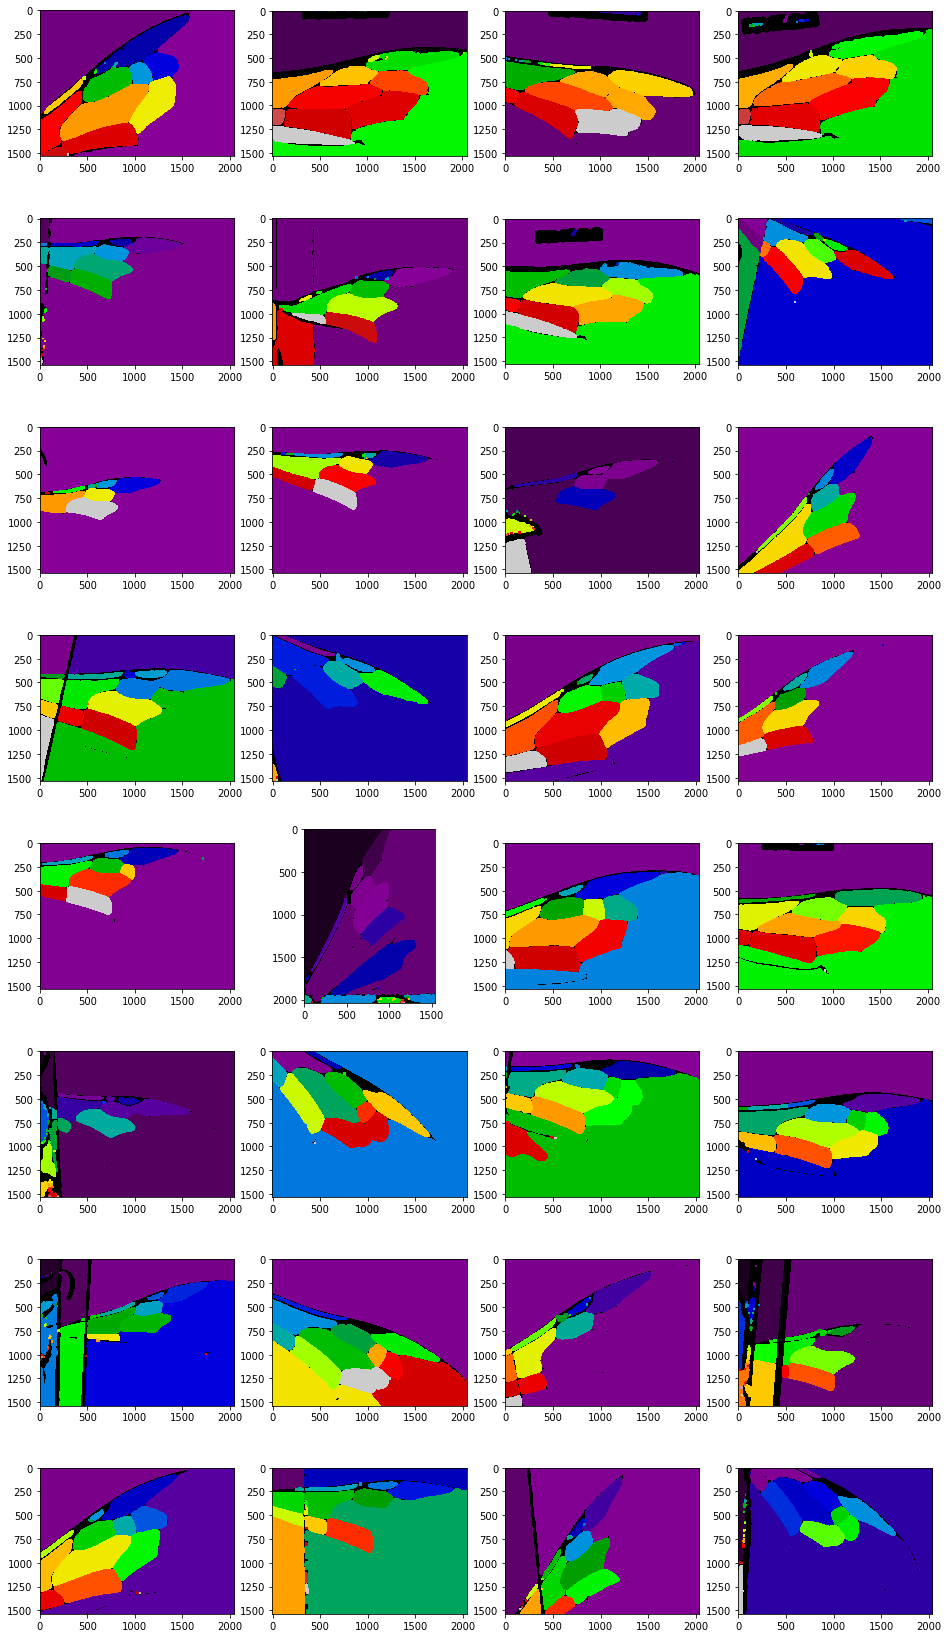

In [7]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process3(img)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(ws, cmap='nipy_spectral')
plt.show()

# Intersections Detection

In [120]:
def intersect(img):
    fig=plt.figure(figsize=(18, 18))

    height, width = img.shape
    step = 60
    intersects = np.full(img.shape, 0)
    for i in range(0, height-step, step//2):
        for j in range(0, width-step, step//2):
            
            colors = set()
            for k in range(i, i+step):
                for l in range(j, j+step):
                    pixel = img[k][l]
                    if pixel != -1 and pixel not in colors:
                        colors.add(pixel)
            if len(colors) >= 4:
                intersects[i+step//2][j+step//2] = 1
                
                
    # mean
    step = 80
    res = [] # list of tuple
    intersects2 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects2[mean[0]][mean[1]] = 1
                res.append(mean)
            else:
                for point in pts:
                    intersects2[point[0]][point[1]] = 255
                    res.append(point)

    fig.add_subplot(2, 1, 1)
    plt.imshow(draw_points(img, res))         
    
    # mean
    step = 100
    res = [] # list of tuple
    intersects3 = np.full(img.shape, 0)
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            
            # print grid
            for i2 in range(0, 5):
                for j2 in range(0, 5):
                    img[i + i2][j + j2] = 255
            
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects2[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                mean = (sum_y // len(pts), sum_x // len(pts))
                intersects3[mean[0]][mean[1]] = 1
                res.append(mean)
            else:
                for point in pts:
                    intersects3[point[0]][point[1]] = 1
                    res.append(point)
                 
   
    fig.add_subplot(2, 1, 2)
    plt.imshow(draw_points(img, res))
    plt.show()
    

    step = 85
    res = [] # list of tuple
    for i in range(0, height-step, step):
        for j in range(0, width-step, step):
            pts = []
            for k in range(i, i+step):
                for l in range(j, j+step):
                    if intersects3[k][l] != 0:
                        pts.append((k, l))
            if len(pts) >= 2:
                sum_x = 0
                sum_y = 0
                for point in pts:
                    sum_y += point[0]
                    sum_x += point[1]
                res.append((sum_y // len(pts), sum_x // len(pts)))
            else:
                for point in pts:
                    res.append(point)
    return res

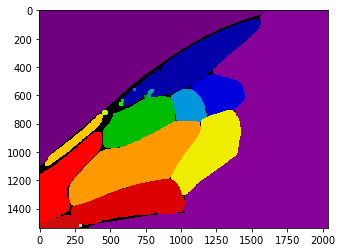

In [121]:
img = train_imgs[0].copy()
ws = process3(img)
plt.imshow(ws, cmap='nipy_spectral')

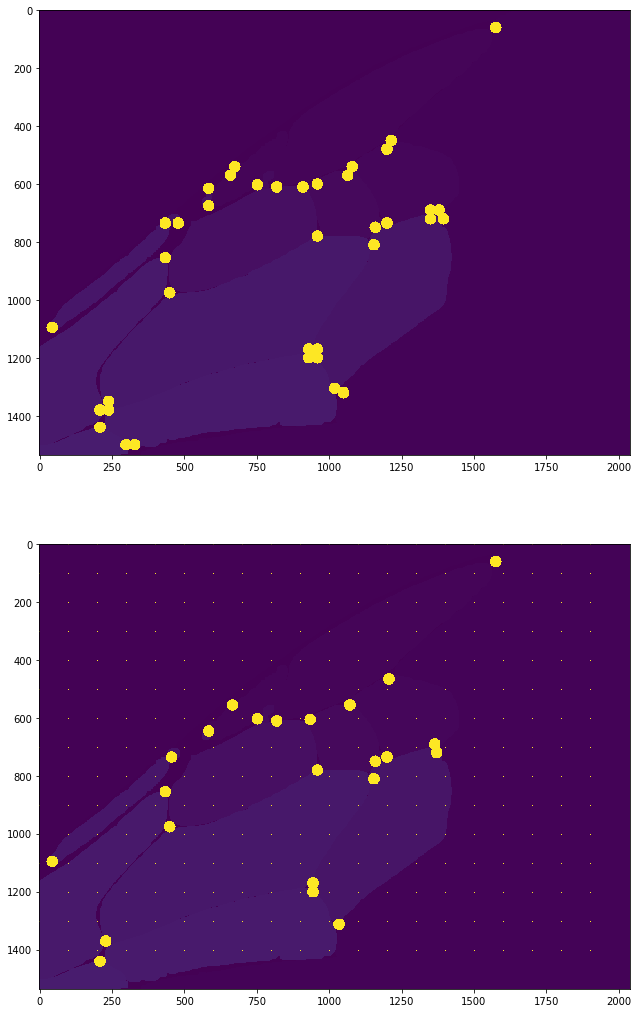

In [122]:
points = intersect(ws)

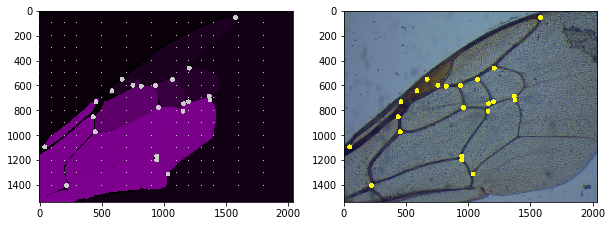

In [123]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(ws, points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(img, points))

plt.show()

# Detection on train images

<Figure size 1152x2160 with 0 Axes>

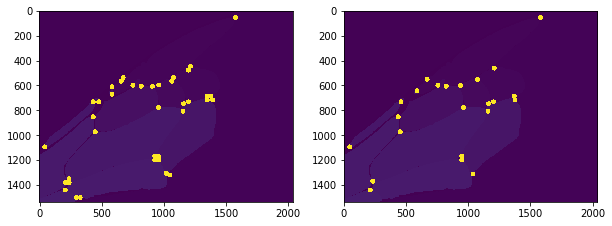

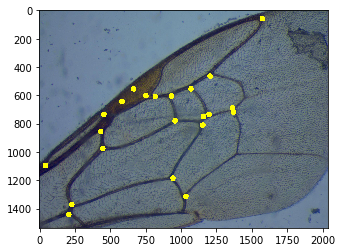

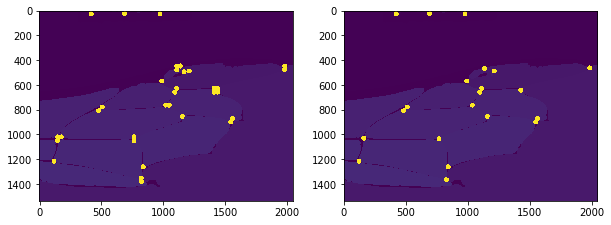

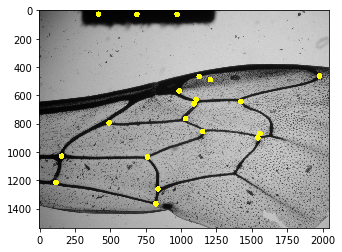

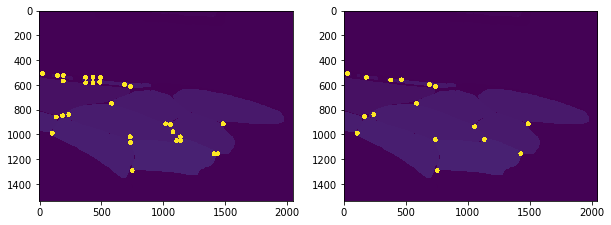

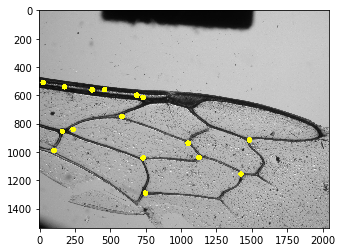

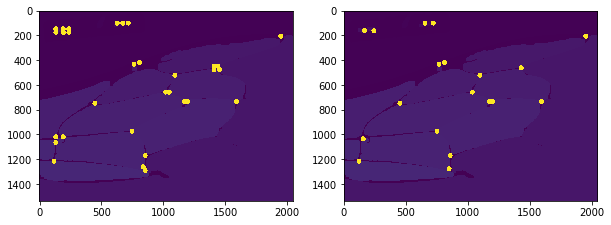

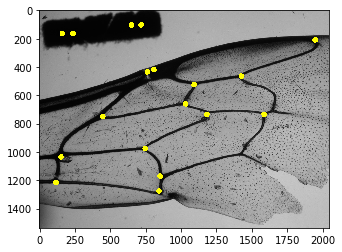

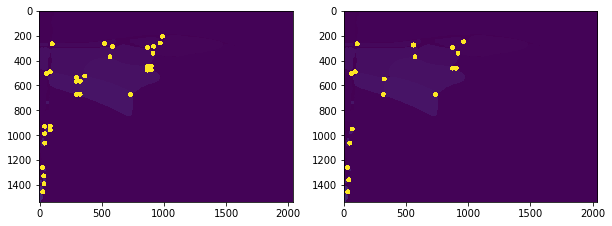

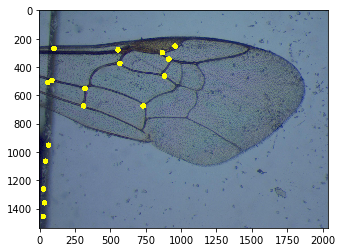

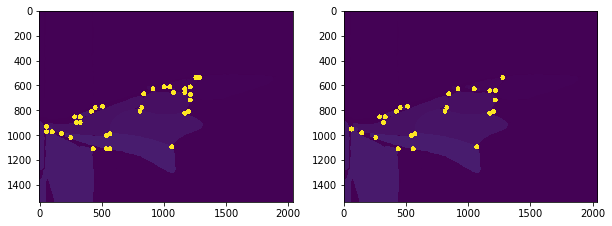

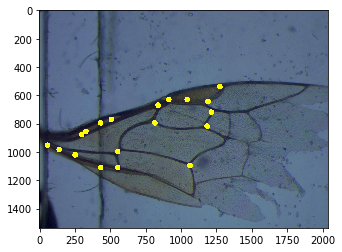

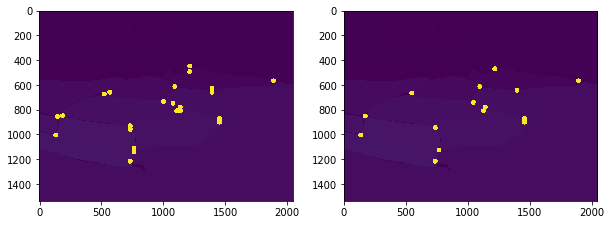

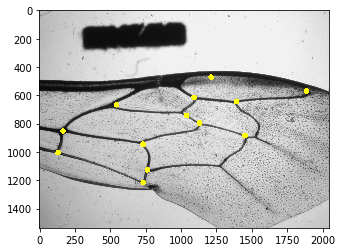

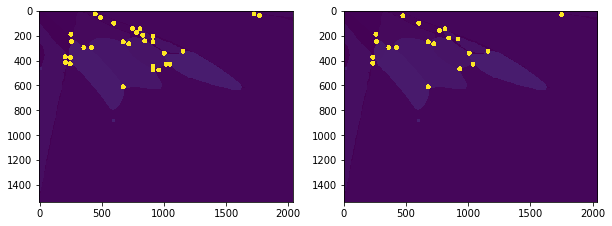

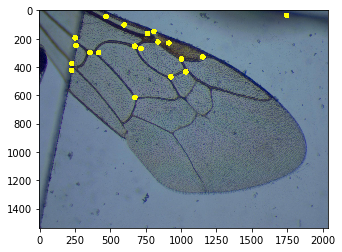

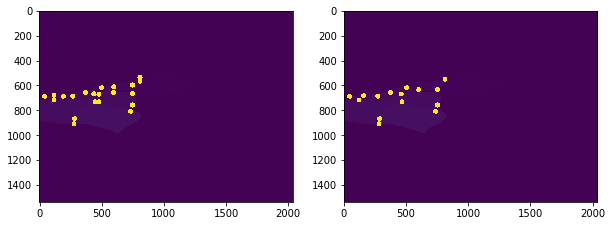

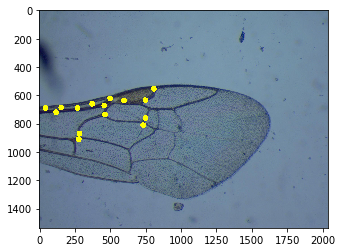

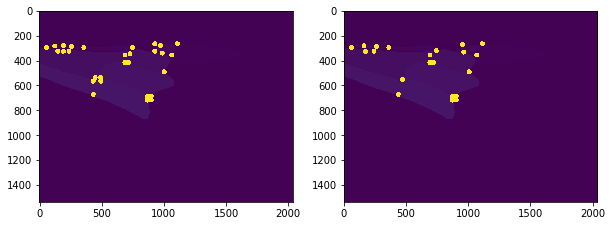

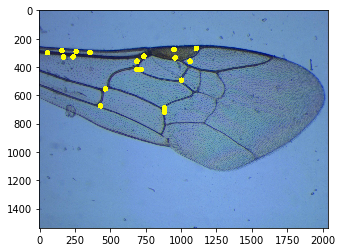

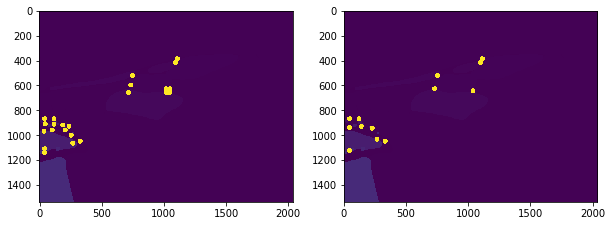

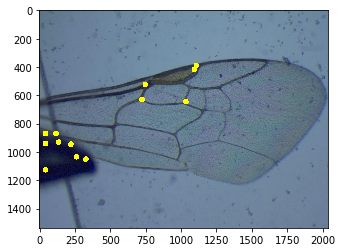

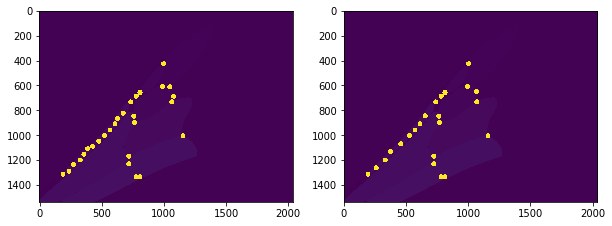

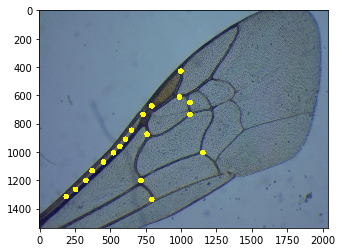

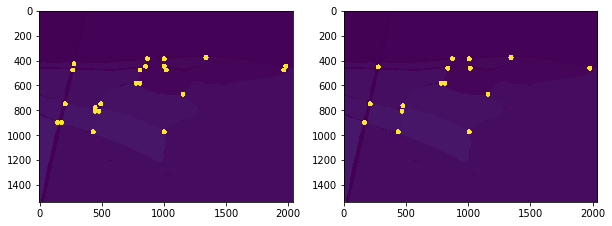

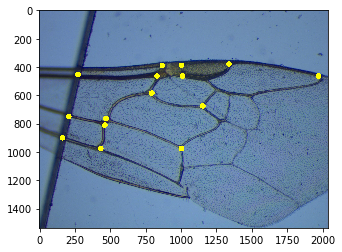

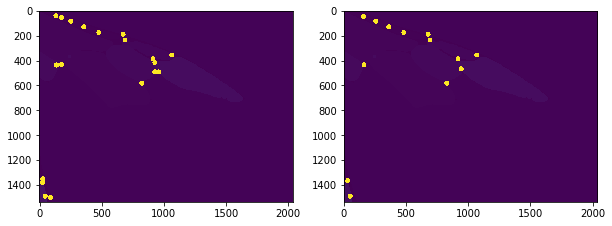

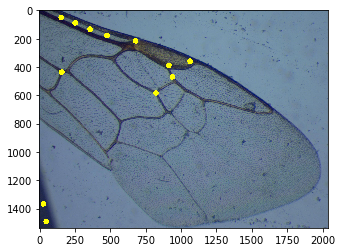

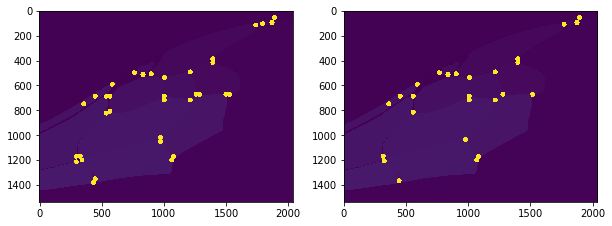

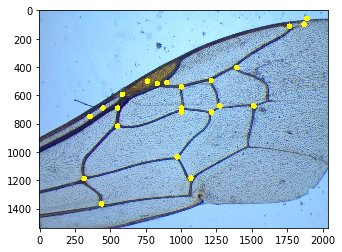

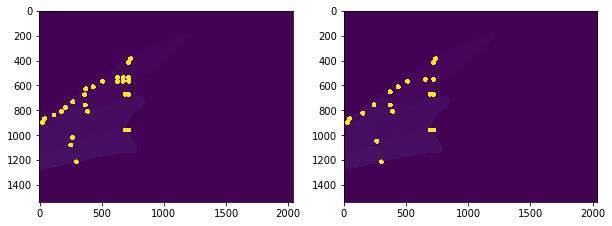

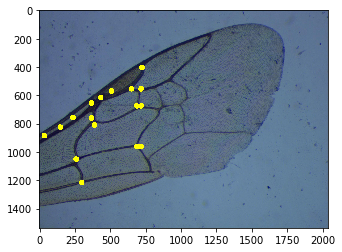

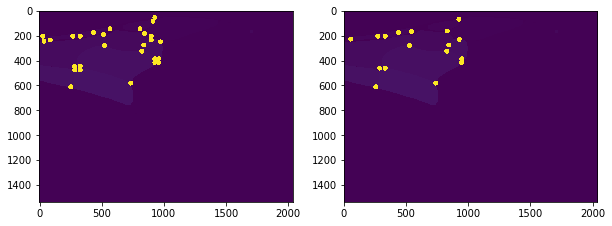

KeyboardInterrupt: 

In [75]:
fig=plt.figure(figsize=(16, 30))
for i in range (0, 32):
    img = train_imgs[i].copy()
    ws = process3(img)
    points = intersect(ws)
    fig.add_subplot(8, 4, i+1)
    plt.imshow(draw_points(img, points))
plt.show()


# Detection on test image

In [22]:
test_img = imageio.imread('../TEST/01_inf.jpg')
test_points = np.genfromtxt('../TEST/01_inf.csv', delimiter=',')
ws = process(test_img)
points = intersect(ws)

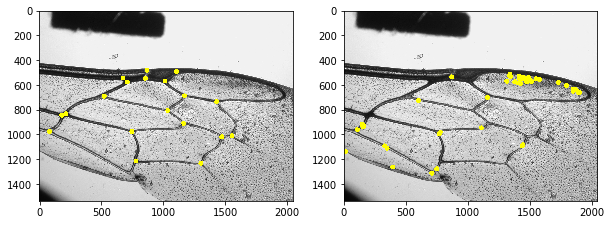

In [23]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1, 2, 1)
plt.imshow(draw_points(test_img, test_points), cmap='nipy_spectral')

fig.add_subplot(1, 2, 2)
plt.imshow(draw_points(test_img, points))

plt.show()

# Compute score

# Colorize edges

In [24]:
def process3(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)
    
    bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    fg = np.uint8(fg)
    unknown = cv2.subtract(bg,fg)
    retval, markers = cv2.connectedComponents(fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    return ws

In [25]:
img = train_imgs[0].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)

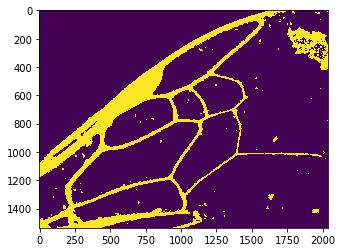

In [26]:
plt.imshow(opening)

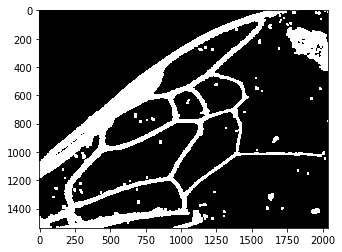

In [27]:
bg = cv2.dilate(opening,kernel,iterations=4)
plt.imshow(bg, cmap='gray')

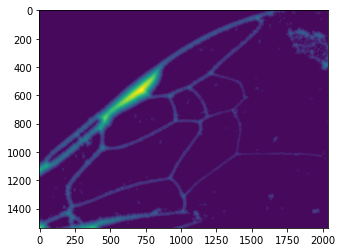

In [28]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
toto = cv2.dilate(dist_transform,kernel,iterations=5)
ws = cv2.watershed(img,np.int32(toto))
retval, markers = cv2.connectedComponents(opening)
all_labels = skimage.measure.label(opening)
plt.imshow(ws)

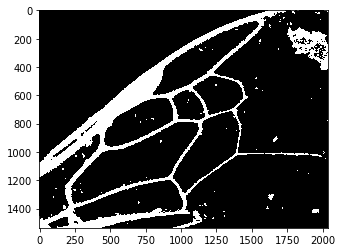

In [29]:
ret, fg = cv2.threshold(dist_transform,0.0*dist_transform.max(),255,0)
fg = np.uint8(fg)
plt.imshow(fg, cmap='gray')

In [37]:
from skimage import data, img_as_float
from skimage.feature import corner_harris


def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""

    plt.plot()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],
             [p[0] for p in filtered_coords],
             'b.')
    plt.axis('off')
    plt.show()


im = img_as_float(data.lena())
filtered_coords = harris(im, min_distance=6)
plot_harris_points(im, filtered_coords)


AttributeError: module 'skimage.data' has no attribute 'lena'

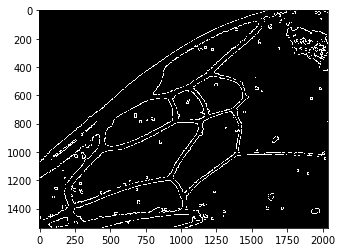

In [30]:
unknown = cv2.subtract(bg,fg)
plt.imshow(unknown, cmap='gray')

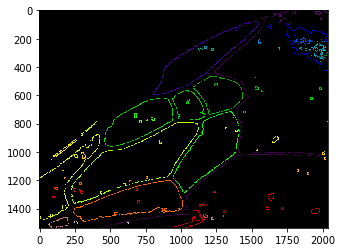

In [31]:
retval, markers = cv2.connectedComponents(unknown)
all_labels = skimage.measure.label(unknown)
plt.imshow(all_labels, cmap='nipy_spectral')

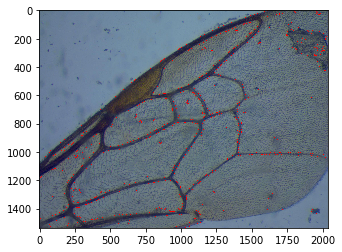

In [32]:
retval, markers = cv2.connectedComponents(fg)
markers = markers+1
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(img)

In [33]:
markers.dtype

dtype('int32')